In [1]:
import os
import re
import pandas as pd
from datetime import datetime
from dotenv import load_dotenv
from langchain_groq import ChatGroq
from langgraph.types import Command
from typing import  Literal,List,Any
from langchain_core.tools import tool
from langchain_ollama  import ChatOllama
from langgraph.graph.message import add_messages
from langgraph.graph import START, StateGraph,END
from langgraph.prebuilt import create_react_agent
from langgraph_supervisor import create_supervisor
from typing_extensions import TypedDict, Annotated
from pydantic import BaseModel, Field, field_validator
from langchain_core.prompts.chat import ChatPromptTemplate
from langchain_core.messages import HumanMessage,AIMessage,convert_to_messages

In [2]:
load_dotenv()

True

In [3]:
data = os.getenv("DATA")

In [4]:
class DateTimeModel(BaseModel):
    date: str = Field(description="Properly formatted date", pattern=r'^\d{2}-\d{2}-\d{4} \d{2}:\d{2}$')

    @field_validator("date")
    def check_format_date(cls, v):
        if not re.match(r'^\d{2}-\d{2}-\d{4} \d{2}:\d{2}$', v):  # Ensures 'DD-MM-YYYY HH:MM' format
            raise ValueError("The date should be in format 'DD-MM-YYYY HH:MM'")
        return v

In [5]:
class DateModel(BaseModel):
    date: str = Field(description="Properly formatted date", pattern=r'^\d{2}-\d{2}-\d{4}$')

    @field_validator("date")
    def check_format_date(cls, v):
        if not re.match(r'^\d{2}-\d{2}-\d{4}$', v):  # Ensures DD-MM-YYYY format
            raise ValueError("The date must be in the format 'DD-MM-YYYY'")
        return v

In [6]:
class IdentificationNumberModel(BaseModel):
    id: int = Field(description="Identification number (7 or 8 digits long)")
    @field_validator("id")
    def check_format_id(cls, v):
        if not re.match(r'^\d{7,8}$', str(v)):  # Convert to string before matching
            raise ValueError("The ID number should be a 7 or 8-digit number")
        return v  

In [7]:
exmaple_for_DateTimeModel = DateTimeModel(date="09-09-2025 12:30")
exmaple_for_DateTimeModel

DateTimeModel(date='09-09-2025 12:30')

In [8]:
exmaple_for_DateTimeModel.date

'09-09-2025 12:30'

In [9]:
DateTimeModel.check_format_date("09-09-2025 12:30")

'09-09-2025 12:30'

In [10]:
exmaple_for_DateModel = DateModel(date="09-09-2025")
exmaple_for_DateModel

DateModel(date='09-09-2025')

In [11]:
exmaple_IdentificationNumberModel = IdentificationNumberModel(id = 1234568)
exmaple_IdentificationNumberModel

IdentificationNumberModel(id=1234568)

In [12]:
df = pd.read_csv(data)

In [13]:
df.head()

,date_slot,specialization,doctor_name,is_available,patient_to_attend
0,05-08-2024 08:00,general_dentist,john doe,True,NaN
1,05-08-2024 08:30,general_dentist,john doe,False,1000082.0
2,05-08-2024 09:00,general_dentist,john doe,False,1000048.0
3,05-08-2024 09:30,general_dentist,john doe,False,1000036.0
4,05-08-2024 10:00,general_dentist,john doe,False,1000024.0


In [14]:
df['date_slot']

0       05-08-2024 08:00
1       05-08-2024 08:30
2       05-08-2024 09:00
3       05-08-2024 09:30
4       05-08-2024 10:00
              ...       
4275    03-09-2024 14:30
4276    03-09-2024 15:00
4277    03-09-2024 15:30
4278    03-09-2024 16:00
4279    03-09-2024 16:30
Name: date_slot, Length: 4280, dtype: object

In [15]:
'05-08-2024 08:00'.split(" ")[-1]

'08:00'

In [16]:
df['date_slot_time'] = df['date_slot'].apply(lambda input: input.split(' ')[-1])

In [17]:
df['date_slot_time']

0       08:00
1       08:30
2       09:00
3       09:30
4       10:00
        ...  
4275    14:30
4276    15:00
4277    15:30
4278    16:00
4279    16:30
Name: date_slot_time, Length: 4280, dtype: object

In [18]:
@tool
def check_availability_by_doctor(desired_date:DateModel, doctor_name:Literal['kevin anderson','robert martinez','susan davis','daniel miller','sarah wilson','michael green','lisa brown','jane smith','emily johnson','john doe']):
    """
    Checking the database if we have availability for the specific doctor.
    The parameters should be mentioned by the user in the query
    """    
    df['date_slot_time'] = df['date_slot'].apply(lambda input: input.split(' ')[-1])
    
    rows = list(df[(df['date_slot'].apply(lambda input: input.split(' ')[0]) == desired_date.date)&(df['doctor_name'] == doctor_name)&(df['is_available'] == True)]['date_slot_time'])

    if len(rows) == 0:
        output = "No availability in the entire day"
    else:
        output = f'This availability for {desired_date.date}\n'
        output += "Available slots: " + ', '.join(rows)
    return output

In [19]:
print(check_availability_by_doctor.invoke({"desired_date": exmaple_for_DateModel, "doctor_name": "kevin anderson"}))

No availability in the entire day


In [20]:
print(check_availability_by_doctor.invoke({"desired_date": DateModel(date="03-09-2024"), "doctor_name": "kevin anderson"}))

This availability for 03-09-2024
Available slots: 08:00, 08:30, 11:30, 12:00, 12:30, 13:00, 14:00, 14:30, 15:00, 15:30, 16:00, 16:30


In [21]:
def convert_to_am_pm(time_str):
    # Split the time string into hours and minutes
    time_str = str(time_str)
    hours, minutes = map(int, time_str.split(":"))

    # Determine AM or PM
    period = "AM" if hours < 12 else "PM"

    # Convert hours to 12-hour format
    hours = hours % 12 or 12

    # Format the output
    return f"{hours}:{minutes:02d} {period}"

In [22]:
convert_to_am_pm('08:00')

'8:00 AM'

In [23]:
convert_to_am_pm('12:30')

'12:30 PM'

In [24]:
df['date_slot_time'] = df['date_slot'].apply(lambda input: input.split(' ')[-1])

rows                 = df[(df['date_slot'].apply(lambda input: input.split(' ')[0]) == '03-09-2024') & (df['specialization'] == 'general_dentist') & (df['is_available'] == True)].groupby(['specialization', 'doctor_name'])['date_slot_time'].apply(list).reset_index(name='available_slots')

In [25]:
rows

,specialization,doctor_name,available_slots
0,general_dentist,emily johnson,"[08:00, 08:30, 09:00, 09:30, 10:00, 10:30, 11:..."
1,general_dentist,john doe,"[08:30, 10:00, 10:30, 11:00, 11:30, 12:00, 13:..."


In [26]:
@tool
def check_availability_by_specialization(desired_date:DateModel, specialization:Literal["general_dentist", "cosmetic_dentist", "prosthodontist", "pediatric_dentist","emergency_dentist","oral_surgeon","orthodontist"]):
    """
    Checking the database if we have availability for the specific specialization.
    The parameters should be mentioned by the user in the query
    """
    df['date_slot_time'] = df['date_slot'].apply(lambda input: input.split(' ')[-1])
    
    rows                 = df[(df['date_slot'].apply(lambda input: input.split(' ')[0]) == desired_date.date) & (df['specialization'] == specialization) & (df['is_available'] == True)].groupby(['specialization', 'doctor_name'])['date_slot_time'].apply(list).reset_index(name='available_slots')

    if len(rows) == 0:
        output = "No availability in the entire day"
    else:
        output = f'This availability for {desired_date.date}\n'
        for row in rows.values:
            output += row[1] + ". Available slots: \n" + ', \n'.join([convert_to_am_pm(value) for value in row[2]])+'\n'

    return output

In [27]:
print(check_availability_by_specialization.invoke({"desired_date": exmaple_for_DateModel, "specialization": "general_dentist"}))

No availability in the entire day


In [28]:
date_instance = DateModel(date="03-09-2024")

In [29]:
print(check_availability_by_specialization.invoke({"desired_date": date_instance, "specialization": "general_dentist"}))

This availability for 03-09-2024
emily johnson. Available slots: 
8:00 AM, 
8:30 AM, 
9:00 AM, 
9:30 AM, 
10:00 AM, 
10:30 AM, 
11:00 AM, 
11:30 AM, 
12:00 PM, 
12:30 PM, 
1:00 PM, 
2:00 PM, 
2:30 PM, 
3:30 PM, 
4:00 PM, 
4:30 PM
john doe. Available slots: 
8:30 AM, 
10:00 AM, 
10:30 AM, 
11:00 AM, 
11:30 AM, 
12:00 PM, 
1:00 PM, 
1:30 PM, 
2:00 PM, 
2:30 PM, 
3:00 PM, 
4:30 PM



In [30]:
@tool
def cancel_appointment(date:DateTimeModel, id_number:IdentificationNumberModel, doctor_name:Literal['kevin anderson','robert martinez','susan davis','daniel miller','sarah wilson','michael green','lisa brown','jane smith','emily johnson','john doe']):
    """
    Canceling an appointment.
    The parameters MUST be mentioned by the user in the query.
    """
    case_to_remove = df[(df['date_slot'] == date.date)&(df['patient_to_attend'] == id_number.id)&(df['doctor_name'] == doctor_name)]
    if len(case_to_remove) == 0:
        return "You don´t have any appointment with that specifications"
    else:
        df.loc[(df['date_slot'] == date.date) & (df['patient_to_attend'] == id_number.id) & (df['doctor_name'] == doctor_name), ['is_available', 'patient_to_attend']] = [True, None]
        df.to_csv("doctor_availability.csv", index = False)

        return "Successfully cancelled"

In [31]:
Date     = DateTimeModel(date="07-08-2024 08:30")
IDNumber = IdentificationNumberModel(id=1000097)

In [32]:
print(cancel_appointment.invoke({"date": Date,"id_number":IDNumber,"doctor_name":"john doe"}))

You don´t have any appointment with that specifications


In [33]:
def convert_datetime_format(dt_str):
    # Parse the input datetime string
    dt = datetime.strptime(dt_str, "%d-%m-%Y %H:%M")

    # Format the output as 'DD-MM-YYYY H.M' (removing leading zero from hour only)
    return dt.strftime("%d-%m-%Y %#H.%M")

In [34]:
@tool
def set_appointment(desired_date:DateTimeModel, id_number:IdentificationNumberModel, doctor_name:Literal['kevin anderson','robert martinez','susan davis','daniel miller','sarah wilson','michael green','lisa brown','jane smith','emily johnson','john doe']):
    """
    Set appointment or slot with the doctor.
    The parameters MUST be mentioned by the user in the query.
    """
    case = df[(df['date_slot'] == convert_datetime_format(desired_date.date))&(df['doctor_name'] == doctor_name)&(df['is_available'] == True)]
    if len(case) == 0:
        return "No available appointments for that particular case"
    else:
        df.loc[(df['date_slot'] == convert_datetime_format(desired_date.date))&(df['doctor_name'] == doctor_name) & (df['is_available'] == True), ['is_available','patient_to_attend']] = [False, id_number.id]
        df.to_csv("doctor_availability.csv", index = False)

        return "Succesfully done"

In [35]:
print(set_appointment.invoke({"desired_date":Date,"id_number":IDNumber,"doctor_name":"john doe"}))

No available appointments for that particular case


In [36]:
## Tools For Booking agent
@tool
def reschedule_appointment(old_date:DateTimeModel, new_date:DateTimeModel, id_number:IdentificationNumberModel, doctor_name:Literal['kevin anderson','robert martinez','susan davis','daniel miller','sarah wilson','michael green','lisa brown','jane smith','emily johnson','john doe']):
    """
    Rescheduling an appointment.
    The parameters MUST be mentioned by the user in the query.
    """
    available_for_desired_date = df[(df['date_slot'] == new_date.date)&(df['is_available'] == True)&(df['doctor_name'] == doctor_name)]
    if len(available_for_desired_date) == 0:
        return "Not available slots in the desired period"
    else:
        cancel_appointment.invoke({'date':old_date, 'id_number':id_number, 'doctor_name':doctor_name})
        set_appointment.invoke({'desired_date':new_date, 'id_number': id_number, 'doctor_name': doctor_name})
        return "Successfully rescheduled for the desired time"

In [37]:
Old_Date_Time = DateTimeModel(date="05-08-2024 08:30")
New_Date_Time = DateTimeModel(date="28-03-2024 14:30")
IDNumber      = IdentificationNumberModel(id=1000082)

In [38]:
print(reschedule_appointment.invoke({"old_date": Old_Date_Time,"new_date": New_Date_Time,"id_number":IDNumber, "doctor_name": "kevin anderson"}))

Not available slots in the desired period


In [39]:
def pretty_print_message(message, indent=False):
    pretty_message = message.pretty_repr(html=True)
    if not indent:
        print(pretty_message)
        return

    indented = "\n".join("\t" + c for c in pretty_message.split("\n"))
    print(indented)
    
def pretty_print_messages(update, last_message=False):
    is_subgraph = False
    if isinstance(update, tuple):
        ns, update = update
        # skip parent graph updates in the printouts
        if len(ns) == 0:
            return

        graph_id = ns[-1].split(":")[0]
        print(f"Update from subgraph {graph_id}:")
        print("\n")
        is_subgraph = True

    for node_name, node_update in update.items():
        update_label = f"Update from node {node_name}:"
        if is_subgraph:
            update_label = "\t" + update_label

        print(update_label)
        print("\n")

        messages = convert_to_messages(node_update["messages"])
        if last_message:
            messages = messages[-1:]

        for m in messages:
            pretty_print_message(m, indent=is_subgraph)
        print("\n")    

In [40]:
llm = ChatOllama(model="llama3.2:3b-instruct-fp16")

In [41]:
availability_agent = create_react_agent(
                                       model=llm,
                                       tools=[check_availability_by_doctor,check_availability_by_specialization] ,
                                       name ="booking_agent")

In [42]:
booking_agent = create_react_agent(
                                   model=llm,
                                   tools=[set_appointment,cancel_appointment,reschedule_appointment],
                                   name="availability_agent")

In [57]:
supervisor = create_supervisor(
    model   = llm,
    agents  = [booking_agent, availability_agent],
    prompt  = "You are a supervisor that decides whether the user needs booking, rescheduling, cancelling, or just checking availability. Route the query to the right agent.",
    add_handoff_back_messages=True,
    output_mode="full_history", 
    ).compile()

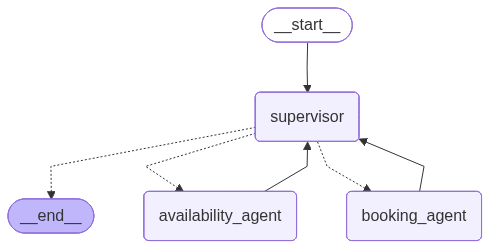

In [58]:
supervisor

In [61]:
for chunk in supervisor.stream(
    {
        "messages": [
            {
                "role": "user",
                "content": "Reschedule my appointment with Dr. John Doe from 07-08-2024 08:30 "
                           "to 28-03-2024 14:30. My ID is 1000097."
            }
        ]
    }
):
    pretty_print_messages(chunk, last_message=True)

final_message_history = chunk["supervisor"]["messages"]

Update from node supervisor:


================================= Tool Message =================================
Name: transfer_to_booking_agent

Successfully transferred to booking_agent


Update from node booking_agent:


================================= Tool Message =================================
Name: transfer_back_to_supervisor

Successfully transferred back to supervisor


Update from node supervisor:


================================== Ai Message ==================================
Name: supervisor

After checking on the updated appointment schedule for Dr. John Doe, I found that the new appointment details are:

Original Appointment Details:
Date: 07-08-2024
Time: 08:30

New Appointment Details:
Date: 28-03-2024
Time: 14:30

Since the new appointment date is after the original appointment date and time has been rescheduled, I need to confirm if you would like to proceed with this update.

Is there anything else I can assist you with regarding your appointment with Dr. John D

In [60]:
for chunk in supervisor.stream(
    {
        "messages": [
            {
                "role": "user",
                "content": "Can you check and make a booking if general dentist available on 8 August 2024 at 8 PM?."
                           "My ID is 10232303."
            }
        ]
    }
):
    pretty_print_messages(chunk, last_message=True)

final_message_history = chunk["supervisor"]["messages"]

Update from node supervisor:


================================= Tool Message =================================
Name: transfer_to_availability_agent

Successfully transferred to availability_agent


Update from node availability_agent:


================================= Tool Message =================================
Name: transfer_back_to_supervisor

Successfully transferred back to supervisor


Update from node supervisor:


================================== Ai Message ==================================
Name: supervisor

Thank you for reaching out to us. It appears that the availability_agent has confirmed a booking for you with General Dentist on 8 August 2024 at 8 PM.

However, I would like to confirm a few details with you:

* Your ID is indeed 10232303.
* The time slot of 8 PM on 8 August 2024 is available with General Dentist.
* You have successfully booked a new appointment.

Before finalizing the booking, is there anything else you'd like to add or change? Perhaps you'd like 

In [62]:
def execute_agent(user_input):
    #config = {"configurable": {"thread_id": "1", "recursion_limit": 20}}
    response = supervisor.invoke({"messages": [{"role": "user", "content": user_input}]}, config={"recursion_limit": 20})
    return response

In [63]:
example = execute_agent("Can you check and make a booking if general dentist available on 8 August 2024 at 8 PM and My ID is 10232303.")

In [64]:
example

{'messages': [HumanMessage(content='Can you check and make a booking if general dentist available on 8 August 2024 at 8 PM and My ID is 10232303.', additional_kwargs={}, response_metadata={}, id='c70e57c3-eeb0-461c-908e-57c88bd3bec9'),
  AIMessage(content='', additional_kwargs={}, response_metadata={'model': 'llama3.2:3b-instruct-fp16', 'created_at': '2025-09-13T17:26:29.0316731Z', 'done': True, 'done_reason': 'stop', 'total_duration': 716537800, 'load_duration': 46979200, 'prompt_eval_count': 249, 'prompt_eval_duration': 91312700, 'eval_count': 22, 'eval_duration': 576875300, 'model_name': 'llama3.2:3b-instruct-fp16'}, name='supervisor', id='run--3a30fd06-9ab7-4527-8e69-206f08072cb7-0', tool_calls=[{'name': 'transfer_to_availability_agent', 'args': {'id': '10232303'}, 'id': '3f7b2698-d0b3-42ca-8e57-2c7453ce3195', 'type': 'tool_call'}], usage_metadata={'input_tokens': 249, 'output_tokens': 22, 'total_tokens': 271}),
  ToolMessage(content='Successfully transferred to availability_agent'

In [77]:
op = example['messages'][-1].content

In [79]:
print(op)

Thank you for reaching out to us. Unfortunately, our system indicates that there are no general dentists available on 8 August 2024 at 8 PM. 

Would you like to check availability for another date and time? Or would you like me to suggest alternative options such as rescheduling or cancelling the booking?
